<a href="https://colab.research.google.com/github/gytj2013/NewPhago/blob/main/newphago_summarize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install konlpy
!pip install git+https://github.com/kakaobrain/pororo.git
!pip install pykrx 
!pip install -U Finance-DataReader
!pip install soynlp

In [ ]:
# 코스피 코스닥 상장 기업 종목번호 사전 생성
from pykrx import stock
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import platform
from datetime import datetime, timedelta

today = datetime.today().strftime("%Y%m%d")
last_week = (datetime.today() - timedelta(7)).strftime("%Y%m%d")

KOSDAQ = stock.get_market_ticker_list(market="KOSDAQ")
KOSPI = stock.get_market_ticker_list(market="KOSPI")

def return_name():
    Company = {}

    for ticker in KOSDAQ:
        Value =stock.get_market_ticker_name(ticker)
        Company[Value]=ticker # 기업명, 종목번호, 코스닥 리스트에 추가
      
    for ticker in KOSPI:
        Value =stock.get_market_ticker_name(ticker)
        Company[Value]=ticker # 기업명, 종목번호, 코스닥 리스트에 추가
 
    return Company;

In [ ]:
# 뉴스 요약
from bs4 import BeautifulSoup
import requests
from pororo import Pororo

bullet_summ = Pororo(task="text_summarization", lang="ko", model="bullet")
abs_summ = Pororo(task="text_summarization", lang="ko", model="abstractive")

def summerize_news(url):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36"}
    req = requests.get(url, headers=headers)
    soup = BeautifulSoup(req.text, 'html.parser')
    body = soup.find_all(id='dic_area')
    if len(body) > 0:
        text = body[0].text
        output_bullet = bullet_summ(text,
                                  beam=5,
                                  len_penalty=0.6,
                                  no_repeat_ngram_size=3,
                                  top_k=50,
                                  top_p=0.7)
        summary_output = abs_summ(text,
                                  beam=5,
                                  len_penalty=0.6,
                                  no_repeat_ngram_size=3,
                                  top_k=50,
                                  top_p=0.7
                                  )
        return output_bullet, summary_output
    else:
        return "error"

In [ ]:
# 요약문 감정 분석
from pororo import Pororo

dataset1 = Pororo(task='sentiment',model='brainbert.base.ko.shopping', lang='ko') # 네이버 쇼핑 데이터셋
#dataset2 = Pororo(task='sentiment', model='brainbert.base.ko.nsmc', lang='ko') # 네이버 영화 리뷰 데이터셋

def forecast(sum):
  return dataset1(sum)

In [ ]:
# 기업명 추출
from pororo import Pororo

def extract_company(sum, CompanyDic):
  company_name = CompanyDic.keys()
  ner = Pororo(task="ner", lang="ko")
  companyL = []
  candidateL = []
  for word in ner(sum):
    if word[1]=='ORGANIZATION' :
      candidateL.append(word[0])
      if word[0] in company_name and word[0] not in companyL :
        companyL.append(word[0])
  if len(companyL) == 0 :
    return editDis(company_name, candidateL)
  else :
    return companyL[0]

In [ ]:
# 기업 주가 정보
from pykrx import stock
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import platform
from datetime import datetime, timedelta

today = datetime.today().strftime("%Y%m%d")
last_week = (datetime.today() - timedelta(7)).strftime("%Y%m%d")

def company_info(company, CompanyDic):
  ticker = CompanyDic[company]
  info_a = stock.get_market_ohlcv(last_week, today, ticker)
  print(info_a) #주가
  info_b = stock.get_market_cap(last_week, today, ticker)
  print(info_b) #시가총액, 거래량, 거래대금, 상장주식수 
  info_c = stock.get_exhaustion_rates_of_foreign_investment(last_week, today, ticker)
  print(info_c) #외국인 보유량 및 외국인 한도소진율
  info_d = stock.get_market_fundamental(last_week, today, ticker)
  print(info_d) #DIV/BPS/PER/EPS
  info_e = stock.get_shorting_volume_by_date(last_week, today, ticker)
  print(info_e) #공매도 현황
  info_g = fdr.DataReader(symbol=ticker, start= "2020")
  fig = plt.figure(figsize=(14, 6))
  ax = fig.add_subplot(1, 1, 1)
  ax.plot(info_g['Close'])
  ax.set_xlabel("Date")
  ax.set_ylabel(ticker)
  ax.set_title("stock price")
  plt.grid(True, axis='y')
  plt.show() #주가그래프
  return 0

In [ ]:
# URL 가져오기
import re
from datetime import datetime
import requests

def getURL() :

  # 오늘 날짜 형식화
  now=datetime.now()
  now=str(now)
  year=now[0:4]
  month=now[5:7]
  day=now[8:10]
  res=year+month+day

  user_agent = "'Mozilla/5.0"
  headers ={"User-Agent" : user_agent}

  page_num = 1
  max_page_num = 1
  urls = []
  while page_num<=max_page_num:
    page_url = "http://news.naver.com/main/list.naver?sid2=258&sid1=101&mid=shm&mode=LS2D&date=" + str(res) + "&page=" + str(page_num) + ""
    response = requests.get(page_url, headers=headers)
    html = response.text
    # url 추출
    url_frags = re.findall('<a href="(.*?)"',html)
    for url_frag in url_frags:
        if "article" in url_frag:
          if "ranking" not in url_frag and url_frag[-3:]=="101":
            urls.append(url_frag)
    page_num+=1
  return set(urls)

In [ ]:
# edit distance 활용해서 정확도 높이기
# 예) 현대자동차 -> 현대차 (종목명으로 변환)
from soynlp.hangle import levenshtein
from soynlp.hangle import jamo_levenshtein

def editDis(company_name, candidateL) :
  minSim = 'default'
  minScore = 3
  candidateL.append('에쓰오일')
  for l in candidateL :
    for c in company_name :
      tmp = levenshtein(c, l)
      if tmp < minScore :
        minSim = c
        minScore = tmp
  return minSim

요약 : 미국 대통령이 삼성전자의 반도체 공장을 견학하는 등 한·미 양국 사이에 새로운 투자 협력 관계가 조성될 것이라는 기대감을 보이며 조 바이든 미국 대통령 방한을 계기로 국내 대기업들이 미국 현지 공장 신설 등 ‘대미 투자’ 계획을 내놓을 것으로 보인다.

예측 : Positive

기업명 : 삼성전자

               시가     고가     저가     종가       거래량
날짜                                              
2022-05-13  65300  66700  65200  66500  14551536
2022-05-16  67100  67400  66100  66300  11937555
2022-05-17  66600  67900  66600  67600  15680447
2022-05-18  68300  68700  67600  68100  16486319
2022-05-19  66500  67600  66500  67500  17073727
2022-05-20  67800  68400  67700  68000  12023540
                       시가총액       거래량           거래대금       상장주식수
날짜                                                              
2022-05-13  396990539575000  14551536   962476162900  5969782550
2022-05-16  395796583065000  11937555   796060691900  5969782550
2022-05-17  403557300380000  15680447  1058322764800  5969782550
2022-05-18  406542191655000  16486319  1122585202585  5969782550
2022-05-19  402960322125000  17073727  11477

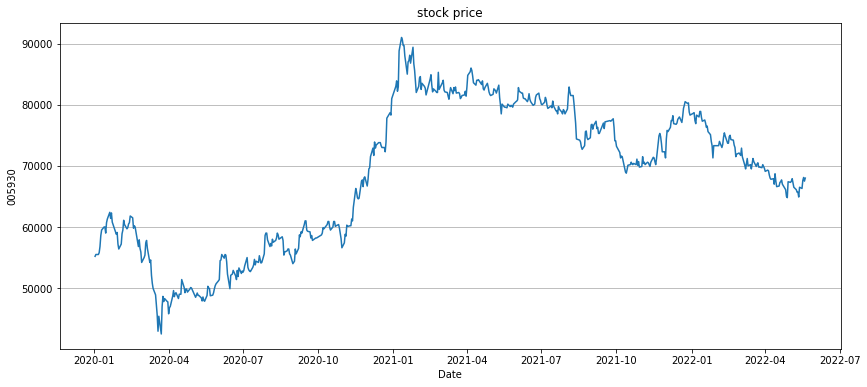

0

In [ ]:
main, sum = summerize_news('https://n.news.naver.com/mnews/article/032/0003148141?sid=101')
print("요약 : "+sum+"\n")
print("예측 : "+forecast(sum)+"\n")
company = extract_company(sum, return_name())
print("기업명 : "+company+"\n")
company_info(company, return_name())

In [ ]:
#from pororo import Pororo

#abs_summ = Pororo(task="text_summarization", lang="ko", model="abstractive")

text = '현대자동차가 싱가포르 생산센터에서 만들어지는 전기차들을 소비자들에게 직접 판매하는 방안을 추진 중이라고 현지 일간 스트레이츠 타임스가 20일 보도했다. \
    신문은 현대차그룹 싱가포르 글로벌 혁신센터(HMGICS)가 최근 자사 웹사이트 및 구인·구직 소셜미디어 링크드인에 채용 리스트를 게시했다며 여기에는 운행 증명서 입찰과 차량 등록·인도 등의 업무가 포함된 판매 기획자도 포함돼 있다고 전했다. \
    이는 소매 영업에 특화된 업무이자 전통적으로 제조업체가 아닌 판매업자들의 영역이라고 신문은 덧붙였다. 현재 현대차의 싱가포르 판매업체는 지난 1986년부터 계약을 맺은 Komoco다.'
summary_output = abs_summ(text,
                          beam=5,
                          len_penalty=0.6,
                          no_repeat_ngram_size=3,
                          top_k=50,
                          top_p=0.7
                          )
print(summary_output)
company = extract_company(summary_output, return_name())
print(company)

현지 스트레이츠 타임스 신문은 20일 현대자동차가 싱가포르 생산센터에서 만들어지는 전기차들을 소매 영업에 특화된 업무이자 전통적으로 제조업체가 아닌 판매업자들의 영역이었던 운행 증명서 입찰과 차량 등록·인도 등의 업무를 포함하여 소비자들에게 직접 판매하는 방안을 추진하고 있다고 보도했다.
현대차


In [ ]:
# 주가 api 이용해서 주가 정보 받아오기
from urllib import parse 
from ast import literal_eval 
import requests 
from datetime import datetime

def get_sise(code) : 
  today = datetime.today().strftime("%Y%m%d")
  get_param = { 
      'symbol':code, 
      'requestType':1, 
      'startTime':today, 
      'endTime':today, 
      'timeframe':'day'
      } 
  get_param = parse.urlencode(get_param) 
  url="https://api.finance.naver.com/siseJson.naver?%s"%(get_param)
  response = requests.get(url) 
  return literal_eval(response.text.strip()) 

get_sise('005930')

In [ ]:
# json 파일 생성

def makeJson(newsData, dic) :
  data = {}
  data['company'] = []
  idx = 0
  for key, value in dic.items():
    data['company'].append({
      "company_name" : key,
      "ticker" : value,
      "stock_graph" : '',
      "stock_info" : [],
      "news" : []
    })
    stockInfo = get_sise(value)
    for i in range(0, len(stockInfo[0])) :
      data['company'][idx]['stock_info'].append({
        stockInfo[0][i] : stockInfo[1][i]
      })
    idx+=1
    #print(data)
  companyL = list(dic.keys())
  for key, value in newsData.items():
    idx = companyL.index(key)
    data['company'][idx]['news'] = value
  return data


In [ ]:
# 뉴스 파일 생성

def makeNewsJson() :
  urlL = ['https://n.news.naver.com/mnews/article/277/0005088162?sid=101'] #list(getURL())
  news = {}
  for u in urlL :
    impo, sum = summerize_news(u)
    fore = forecast(sum)
    companyL = extract_company(sum, return_name())
    name = ""
    if len(companyL)!=0 :
      name = companyL[0]
    if name=="" :
      continue
    if name not in news :
      news[name] = [{
          "important" : impo,
          "summary" : sum,
          "sentiment" : fore,
          "url" : u
      }]
    else :
      news[name].append({
          "important" : impo,
          "summary" : sum,
          "sentiment" : fore,
          "url" : u
      })
    #print(news)
  return news
makeNewsJson()

{'롯데케미칼': [{'important': ['롯데케미칼 日지사 상무 합류', ' 인수·합병 담당할 듯'],
   'sentiment': 'Positive',
   'summary': '롯데 황동빈 롯데그룹 회장의 장남 신유열씨가 최근 롯데케미칼 일본 지사에 상무로 합류했는데, 일본 롯데, 롯데홀딩스 업무도 겸직하면서 향후 인수·합병(M&A) 업무를 담당할 것으로 알려졌다.',
   'url': 'https://n.news.naver.com/mnews/article/277/0005088162?sid=101'}]}

In [ ]:
makeJson(makeNewsJson(), return_name())

{'company': [{'company_name': '롯데케미칼',
   'news': [{'important': ['롯데케미칼 日지사 상무 합류', ' 인수·합병 담당할 듯'],
     'sentiment': 'Positive',
     'summary': '롯데 급여 신유열씨는 2020년 일본 롯데와 일본 롯데홀딩스에 입사해 근무했으며 최근 롯데케미칼 일본 지사에 미등기 임원으로 참여했는데, 일본 롯데, 롯데홀딩스 업무도 겸직하면서 향후 인수·합병(M&A) 업무를 담당할 것으로 보인다.',
     'url': 'https://n.news.naver.com/mnews/article/277/0005088162?sid=101'}],
   'stock_graph': '',
   'stock_info': [{'날짜': '20220517'},
    {'시가': 193000},
    {'고가': 198000},
    {'저가': 193000},
    {'종가': 196500},
    {'거래량': 107787},
    {'외국인소진율': 24.3}],
   'ticker': '011170'}]}